In [1]:
from multitme.data import IMC_data, IMC_alignment
from multitme.model import SSVAE
import numpy as np

### Read IMC data

In [2]:
imc_file = '/Users/hrzhang/Downloads/05122023_Vivek_S21_10641_A4_Group1.mcd'
# IMC channel for nuclues segmentation
segmentation_channels = ['DNA1', 'DNA2']
selected_protein = ['HH3', 'CC10', 'ARG1', 'CD45RA', 'aSMA','IFNg', 'PD_L1', 'CD163','CD14', 'CD11b', 
                    'PD_1','CD31', 'CD206', 'LAG3', 'TOX', 'FoxP3', 'CD4',  'TGFb', 'NCR1', 'MMP9', 
                    'CD20', 'CD8a', 'CD33', 'pSTAT3', 'HLA_DR', 'IL_1beta', 'GranzymeB', 'Ki_67', 'CD56', 
                    'CD3', 'CTLA4', 'GITR', 'SPP1', 'SFTPC', 'CD16', 'CD11c', 'PanCK', 'CD68', 'CD15']

# 
A4_IMC = IMC_data(imc_file, segmentation_channels=segmentation_channels, data_path='A4_data')
A4_IMC.process_data(pixel_sum_threshold=3, selected_protein=selected_protein)

Load IMC: 6it [00:11,  1.87s/it]
Checking for cached data
Checking NuclearSegmentation-75.tar.gz against provided file_hash...
NuclearSegmentation-75.tar.gz with hash efc4881db5bac23219b62486a4d877b3 already available.
Extracting /Users/hrzhang/.deepcell/models/NuclearSegmentation-75.tar.gz
Successfully extracted /Users/hrzhang/.deepcell/models/NuclearSegmentation-75.tar.gz into /Users/hrzhang/.deepcell/models
No training configuration found in save file, so the model was *not* compiled. Compile it manually.
Cell segmentation acquisition 0
Converting image dtype to float
Cell segmentation acquisition 1
Converting image dtype to float
Cell segmentation acquisition 2
Converting image dtype to float
Cell segmentation acquisition 3
Converting image dtype to float
Cell segmentation acquisition 4
Converting image dtype to float
Cell segmentation acquisition 5
Converting image dtype to float


### Align the consecutive slices of IMC and ST

In [3]:
bayesTME_prop = np.load('../../projects/multitme/A4_beta_full_post_prob.npy')[-100:].mean(axis=0)
analysis = IMC_alignment('A4_data')
cell_ST, all_edges= analysis.process_acquisition(bayesTME_prop)

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


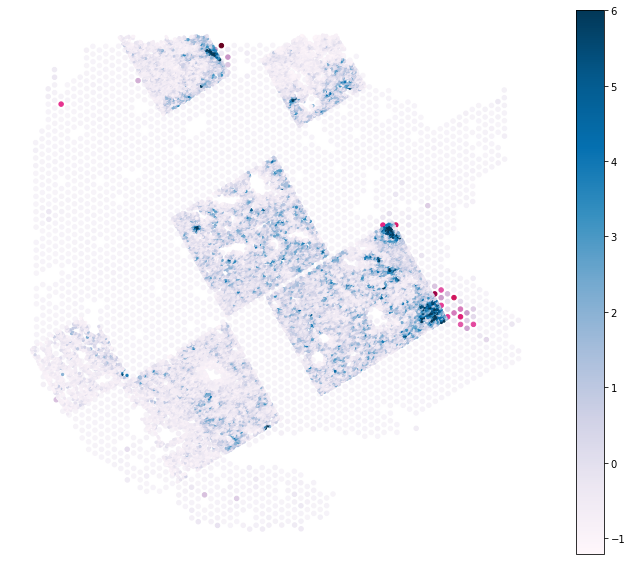

In [4]:
z_val = np.load('A4_data/imc_reads/Obs_imc.npy')
z_log = (z_val - z_val.mean(axis=0))/(np.std(z_val, axis=0))
spatial_ref = np.load('A4_data/imc_reads/ST_spatial_reference.npy')

import matplotlib.pyplot as plt
all_imc_cells = np.load('A4_data/imc_meta/all_imc_cells.npy')
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.scatter(analysis.spot_pos[0], analysis.spot_pos[1], c=bayesTME_prop[:, 5], cmap='PuRd', s=20)
im = ax.scatter(all_imc_cells[:, 0], all_imc_cells[:, 1], 
                 s=5, c=z_log[:, 16], cmap='PuBu', vmax=6)
ax.set_axis_off()
plt.colorbar(im, ax=ax)
plt.show()

### IMC celltyping

In [5]:
ST_celltypes = np.array(['AT1', 'AT2', 'B.plasma', 'Basal', 'CD4 T', 'CD8 T', 'Ciliated', 'Club',
                         'Club/Ciliated transition', 'DC', 'EC', 'Fibroblast', 'Macrophage', 'Monocyte',
                         'NK', 'Neutrophil', 'PMN-MDSC', 'Pericyte/Smooth muscle', 'Treg', 'Tumor',
                         'Tumor transition', 'pDC'])
cell_types = ['CD4 T', 'CD8 T', 'Tumor']
biomarkers = ['CD4', 'CD8a', 'PanCK']

ss_vae = SSVAE(ST_celltypes, 'A4_data', output_size=22, input_size=39, z_dim=50, hidden_layers=[100])
train_loss_sup, train_loss_unsup = ss_vae.fit(cell_types, biomarkers, batch_size=100, num_epochs=200, 
                                              learning_rate=0.001, betas=(0.9, 0.999))

SSVAE initialized with output_size=22, input_size=39, z_dim=50, hidden_layers=[100], aux_loss_multiplier=100


  0%|          | 0/200 [00:00<?, ?epoch/s]

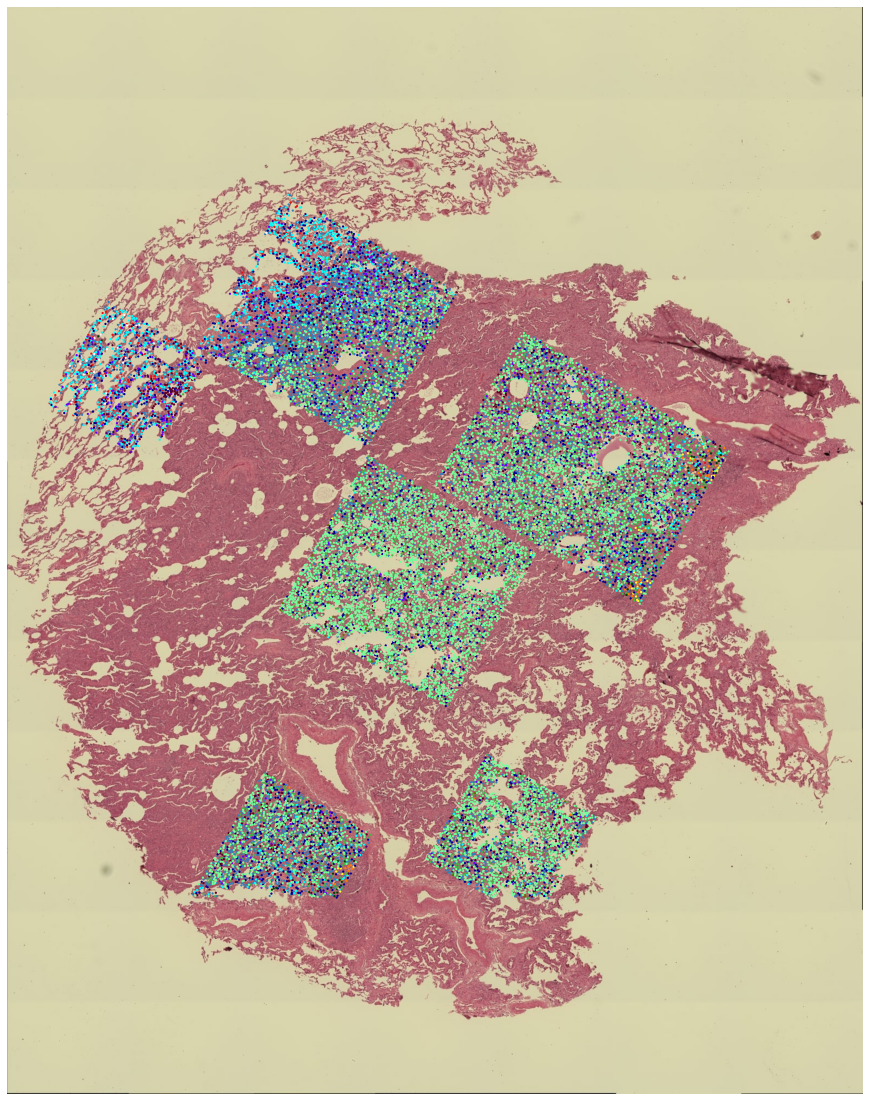

In [6]:
ss_vae.plot_IMConST()